In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


%matplotlib inline


In [70]:
class NeuralNetwork():
    def __init__(self,X,Y,nn_layers,n_iters=2000,alpha = 0.01,lambda_=10):
        self.X = X
        self.Y = Y
        self.nn_layers= nn_layers
        self.n_iters= n_iters
        self.alpha= alpha
        self.lambda_= lambda_
        self.params = self.random_weights_initialization(nn_layers)
        self.fp_cache = None
        self.cost = None
        
    def tanh(self,z):
        return np.tanh(z)
    def sigmoid(self,z):
        return 1 / (1+np.exp(-z))
    def sigmoid_deriv(self,z):# z --> sigmoid(Z)
        return z * (1-z)
    def tanh_deriv(self,z): # z --> tanh(Z)
        return 1 - (z)**2
    def relu(self,Z):
        z_copy = np.array(Z,copy=True)
        return np.maximum(0,z_copy)
    def relu_backward(self,dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    
    def random_weights_initialization(self,n_layers):
        params = {}

        # n_layers --> (len-1) is no of layers and elements of list are no of neurons in (index+1)th layer

        for i in range(1,len(n_layers)):
            params["W"+str(i)] = np.random.randn(n_layers[i-1],n_layers[i])* np.sqrt(2/n_layers[i-1])
            params["b"+str(i)] = b3 = np.zeros((1,n_layers[i]))

        return params
    
    
    
    def forward_prop(self,input_X,parameters):   
        cache = {
            "A0":input_X
        }
        last_index = int(len(parameters)/2)
        for i in range(1,last_index):
            cache["Z"+str(i)] = np.dot(cache["A"+str(i-1)],parameters["W"+str(i)]) + parameters["b"+str(i)]
            cache["A"+str(i)] = self.relu(cache["Z"+str(i)])

        cache["Z"+str(last_index)] = np.dot(cache["A"+str(last_index-1)],
                                            parameters["W"+str(last_index)])  + parameters["b"+str(last_index)]
        cache["A"+str(last_index)] = self.sigmoid(cache["Z"+str(last_index)])
        self.fp_cache=cache
        return cache["A"+str(last_index)],cache
    
    
    def compute_cost(self,pred_output,actual_output,parameters,lamdba):    
        A = pred_output
        y =actual_output
        m = y.shape[0]
        norm=0
        for i in range(1,int(len(parameters)/2)):
            norm += np.linalg.norm(parameters["W"+str(i)])

        cost_ =  (1./m)* np.sum((A-y)**2) + (lamdba * norm)/(2*m)
        return np.squeeze(cost_)


    def get_accuracy_value(self,Y_hat, Y):
        testing = Y_hat.copy()
        testing[Y_hat>0.5]= 1 
        testing[Y_hat <= 0.5]=0
        return (testing == Y).all(axis=1).mean()
    
    def backward_prop(self,Y,cache,parameters):

        last_index = int(len(parameters)/2)
        m = Y.shape[0]
        back_cache = {}

        delta3  = 2*(cache["A"+str(last_index)] - Y) * self.sigmoid_deriv(cache["A"+str(last_index)])
        back_cache["dW"+str(last_index)] = (np.dot(cache["A"+str(last_index-1)].T,delta3)/ m) + (self.lambda_/m) * parameters["W"+str(last_index)]
        back_cache["db"+str(last_index)] =np.sum(delta3,axis=0,keepdims=True)/ m 

        delta = delta3
        for i in reversed(range(1,last_index)):
            delta =self.relu_backward(np.dot(delta,parameters["W"+str(i+1)].T),cache["Z"+str(i)])
            back_cache["dW"+str(i)] = (np.dot(cache["A"+str(i-1)].T,delta) / m) + (self.lambda_/m) * parameters["W"+str(i)]
            back_cache["db"+str(i)] = np.sum(delta,axis=0,keepdims=True)/ m

        for i in range(1,(last_index)):
            assert (parameters["W"+str(i)].shape == back_cache["dW"+str(i)].shape) 

        return back_cache
    
    def update_params(self,params,backward_cache,learning_rate,lamdba,m):
        ferb = (learning_rate * lamdba)/m
        last_index = int(len(params)/2)
        for i in range(1,last_index+1):
            params["W"+str(i)] = (1-ferb)*params["W"+str(i)]- (learning_rate * backward_cache["dW"+str(i)])
            params["b"+str(i)] = params["b"+str(i)]- (learning_rate * backward_cache["db"+str(i)])
        return params
    
    def train(self,print_cost=False):    
        params  = self.random_weights_initialization(self.nn_layers)
        J_cost =[]
        print("Starting Training")
        for i in range(self.n_iters):

            A3,cache = self.forward_prop(self.X,params)
            J = self.compute_cost(A3,self.Y,params,self.lambda_)
            J_cost.append(J)
            if print_cost:
                if (i%100 == 0):
                    print("iter:",str(i),"cost:",str(J),"Accuracy:",str(self.get_accuracy_value(A3,self.Y)))
                    print("----------------------------------------------------------------------")

            back_cache = self.backward_prop(self.Y,cache,params)

            self.params  = self.update_params(params,back_cache,self.alpha,self.lambda_,self.X.shape[0])
        self.cost  = J_cost
        print("Training Done.")
        print("With \n" + "Cost: "+str(J)+" Accuracy: "+str(self.get_accuracy_value(A3,self.Y)))
        

    
    def predict(self,testX,threshold):    
        A3,_=self.forward_prop(testX,self.params)
#         output = np.array(cache["A"+str(last_index)],copy=True)
#         output[output > threshold] = 1
#         output[output <= threshold] = 0    
        
        predictions = np.round(A3)
        return predictions

#         return output
    
    def evaluate(self,input_X,output_y,threshold=0.5):
        predictions = self.predict(input_X,threshold)
        print( " precision:" , str(precision_score(output_y,predictions))[:5],"\n",
        "recall:",str(recall_score(output_y,predictions))[:5],"\n",
        "fl score:",str(f1_score(output_y,predictions))[:5],"\n",
        "accuracy:",str((predictions == output_y).all(axis=1).mean())[:5])
        results = confusion_matrix(output_y,predictions)
        fig, ax = plt.subplots()
        ax.matshow(results)
        for (i, j), z in np.ndenumerate(results):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
        plt.show()
    
    def plot_cost(self):
        plt.plot(np.arange(len(self.cost)),self.cost)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Cost")
        plt.show()

In [58]:
import sys, numpy as np 
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Getting the Data for 1 and 0 to classify:

In [81]:
y_1_train = np.where(y_train == 1)
y_0_train = np.where(y_train == 0)
index_train =np.append(y_1_train[0],y_0_train[0])
np.random.shuffle(index_train)

y_1_test = np.where(y_test == 1)
y_0_test = np.where(y_test == 0)
index_test =np.append(y_1_test[0],y_0_test[0])
np.random.shuffle(index_test)


# index
x_train= x_train[(index_train)]
y_train= y_train[(index_train)]
x_test= x_test[(index_test)]
y_test= y_test[(index_test)]

print(index_train)


[10692 56110 48488 ... 59521 23589 35409]


0

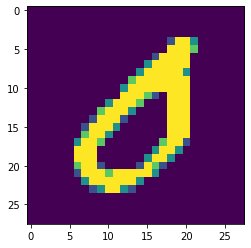

In [82]:
n_samples_train = 12000
i = np.random.randint(0, n_samples_train)
img = Image.fromarray(x_train[i])
plt.imshow(img)

y_train[i]

In [83]:
images, labels = (x_train[0:n_samples_train].reshape(n_samples_train,28*28) /255, y_train[0:n_samples_train].reshape(n_samples_train,1)) 
df = pd.DataFrame(images)
images.shape,labels.shape

((12000, 784), (12000, 1))

In [84]:
# params_ , cost_ = train(images,labels,[images.shape[1],6,4,labels.shape[1]],n_iters=2000,alpha =  0.01,lambda_=10,)
nn_arch=[images.shape[1],6,5,labels.shape[1]]
nn =NeuralNetwork(images,labels,nn_arch,lambda_=0)
nn.train(True)

Starting Training
iter: 0 cost: 0.284063911288903 Accuracy: 0.54675
----------------------------------------------------------------------
iter: 100 cost: 0.025453206179380128 Accuracy: 0.9940833333333333
----------------------------------------------------------------------
iter: 200 cost: 0.012635426779857125 Accuracy: 0.9955833333333334
----------------------------------------------------------------------
iter: 300 cost: 0.008735962773424425 Accuracy: 0.9958333333333333
----------------------------------------------------------------------
iter: 400 cost: 0.006865149357090719 Accuracy: 0.99625
----------------------------------------------------------------------
iter: 500 cost: 0.005754808581547813 Accuracy: 0.9966666666666667
----------------------------------------------------------------------
iter: 600 cost: 0.005015164249641807 Accuracy: 0.997
----------------------------------------------------------------------
iter: 700 cost: 0.0044857139003189285 Accuracy: 0.9970833333333

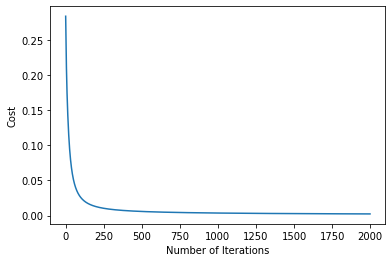

In [85]:
nn.plot_cost()

Testing the Trained Neural Network

In [86]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score ,f1_score


In [87]:
n_test_samples = x_test.shape[0]
testX = x_test.reshape(n_test_samples,28*28)/255
testY = y_test.reshape(n_test_samples,1)


Threshold: 0.5
-------------test set-------------
 precision: 1.0 
 recall: 0.999 
 fl score: 0.999 
 accuracy: 0.999


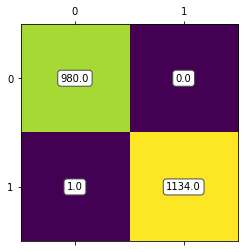

-------------train set-------------
 precision: 0.998 
 recall: 0.997 
 fl score: 0.998 
 accuracy: 0.998


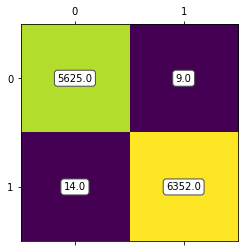

In [88]:
thres = 0.5
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)


Threshold: 0.8
-------------test set-------------
 precision: 1.0 
 recall: 0.999 
 fl score: 0.999 
 accuracy: 0.999


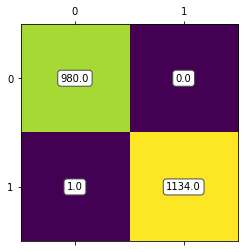

-------------train set-------------
 precision: 0.998 
 recall: 0.997 
 fl score: 0.998 
 accuracy: 0.998


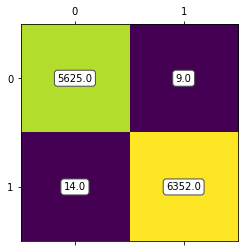

In [89]:
thres = 0.8
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)

Threshold: 0.3
-------------test set-------------
 precision: 1.0 
 recall: 0.999 
 fl score: 0.999 
 accuracy: 0.999


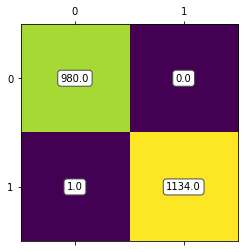

-------------train set-------------
 precision: 0.998 
 recall: 0.997 
 fl score: 0.998 
 accuracy: 0.998


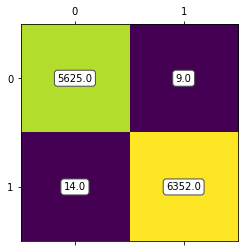

In [90]:
thres = 0.3
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)

Threshold: 0.7
-------------test set-------------
 precision: 1.0 
 recall: 0.999 
 fl score: 0.999 
 accuracy: 0.999


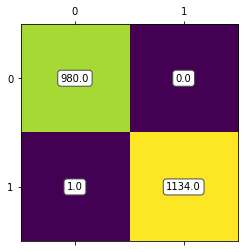

-------------train set-------------
 precision: 0.998 
 recall: 0.997 
 fl score: 0.998 
 accuracy: 0.998


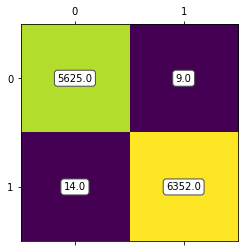

In [91]:
thres = 0.7
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)

Threshold: 0.9
-------------test set-------------
 precision: 1.0 
 recall: 0.999 
 fl score: 0.999 
 accuracy: 0.999


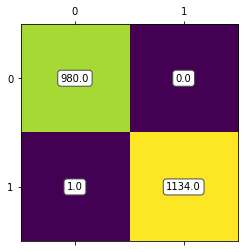

-------------train set-------------
 precision: 0.998 
 recall: 0.997 
 fl score: 0.998 
 accuracy: 0.998


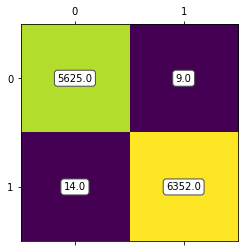

In [92]:
thres = 0.9
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)

In [50]:
(x_train_10, y_train_10), (x_test_10, y_test_10) = mnist.load_data()
x_cross_10 = x_train_10[0:5000]
y_cross_10 = y_train_10[0:5000]
x_train_10 = x_train_10[5000:]
y_train_10 = y_train_10[5000:]

n_train_samples = x_train_10.shape[0]
n_train_labels = y_train_10.shape[0]
n_test_samples = x_test_10.shape[0]
n_test_labels = y_test_10.shape[0]
n_cross_samples = x_cross_10.shape[0]
n_cross_labels = y_cross_10.shape[0]

In [59]:
x_input = x_train_10.reshape(n_train_samples,28*28)/255
y_output = y_train_10.reshape(n_train_labels,1)

y_train_labels = np.zeros((n_train_labels,10))
for i_row,j in enumerate(y_output):
    y_train_labels[i_row][j]=1

x_input.shape,y_train_labels.shape,n_train_samples,n_train_labels

((55000, 784), (55000, 10), 55000, 55000)

In [71]:
nn10 =NeuralNetwork(x_input,y_train_labels,[x_input.shape[1],6,4,y_train_labels.shape[1]])

In [72]:
nn10.train(True)

Starting Training
iter: 0 cost: 2.5174205532178835 Accuracy: 0.0
----------------------------------------------------------------------
iter: 100 cost: 1.5720365810281107 Accuracy: 0.012236363636363635
----------------------------------------------------------------------
iter: 200 cost: 0.9710425465987028 Accuracy: 0.0014181818181818182
----------------------------------------------------------------------
iter: 300 cost: 0.9150027522814834 Accuracy: 0.0
----------------------------------------------------------------------
iter: 400 cost: 0.9065777536009832 Accuracy: 0.0
----------------------------------------------------------------------
iter: 500 cost: 0.8976075037966673 Accuracy: 0.0
----------------------------------------------------------------------
iter: 600 cost: 0.8880042440203452 Accuracy: 0.0
----------------------------------------------------------------------
iter: 700 cost: 0.8787755202105244 Accuracy: 0.00012727272727272728
-----------------------------------------

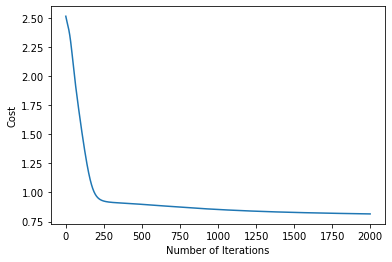

In [73]:
nn10.plot_cost()

In [77]:
nn10.predict(x_cross_10.reshape(n_cross_samples,28*28)/255,y_cross_10.reshape(n_cross_labels,1))[5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [80]:
nn10.evaluate(x_cross_10.reshape(n_cross_samples,28*28)/255,y_cross_10.reshape(n_cross_labels,1))

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets